In [ ]:
! pip install tensorboardX pandas simpletransformers transformers

**RESTART RUNTIME**

In [ ]:
! cp ./drive/My\ Drive/mlin/hindicorpus/*.csv ./

# Hindi sentiment analysis task


In [92]:
import pandas as pd
import numpy as np
import re
import string
#import nltk
#nltk.download('punkt')
#import torch
from tensorflow import keras
import seaborn as sns
from keras.callbacks import TensorBoard
%load_ext tensorboard
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,RocCurveDisplay, auc
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from simpletransformers.classification import ClassificationModel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the necessary datasets

## Base datasets - hi_3500.csv

In [ ]:
# Print the dataframe
df_3500 = pd.read_csv("/content/drive/MyDrive/AI Winter Project/hi_3500.csv", header=0, names=['review', 'sentiment'])
df_3500.shape

(9077, 2)

In [ ]:
print(set(df_3500['sentiment'].values))

{'negative', 'positive', 'neutral'}


In [ ]:
labeler = preprocessing.LabelEncoder()

df_3500['sentiment'] = labeler.fit_transform(df_3500['sentiment'] )
df_3500['sentiment'].value_counts()

2    3254
0    3174
1    2649
Name: sentiment, dtype: int64

In [ ]:
#Validation dataset for the movie review
validation_3500 = pd.read_csv("/content/drive/MyDrive/AI Winter Project/train.csv", header=0, names=['review', 'sentiment'])
validation_3500.head()

review  sentiment
0  ‡§ö‡§Ç‡§¶‡•ç‡§∞‡§Æ‡•ã‡§π‡§® ‡§∂‡§∞‡•ç‡§Æ‡§æ ‡§ï‡•ã-‡§™‡•ç‡§∞‡§°‡•ç‡§Ø‡•Ç‡§∏‡§∞ ‡§î‡§∞ ‡§≤‡•Ä‡§° ‡§ê‡§ï‡•ç‡§ü‡§∞ ‡§Ö‡§ï‡•ç‡§∑...          2
1  ‡§Ö‡§ó‡§∞ ‡§Ü‡§™ ‡§á‡§∏ ‡§´‡§ø‡§≤‡•ç‡§Æ ‡§ï‡•ã ‡§¶‡•á‡§ñ‡§®‡•á ‡§ú‡§æ ‡§∞‡§π‡•á ‡§π‡•à‡§Ç ‡§§‡•ã ‡§∏‡§¨‡§∏‡•á ‡§™‡§π...          0
2  ‡§¨‡•â‡§≤‡•Ä‡§µ‡•Å‡§° ‡§µ‡§æ‡§≤‡•á ‡§ö‡•ã‡§∞‡•Ä-‡§õ‡§ø‡§™‡•á ‡§π‡•â‡§≤‡•Ä‡§µ‡•Å‡§° ‡§´‡§ø‡§≤‡•ç‡§Æ‡•ã‡§Ç ‡§∏‡•á ‡§ï‡§π‡§æ‡§®...          2
3  ‡§¨‡•à‡§®‡§∞ :\n‡§∏‡§Ç‡§ú‡§Ø ‡§¶‡§§‡•ç‡§§ ‡§™‡•ç‡§∞‡•ã‡§°‡§ï‡•ç‡§∂‡§®‡•ç‡§∏ ‡§™‡•ç‡§∞‡§æ.‡§≤‡§ø., ‡§∞‡•Å‡§™‡§æ‡§≤‡•Ä...          0
4  1959 ‡§Æ‡•á‡§Ç ‡§ò‡§ü‡§ø‡§§ ‡§ö‡§∞‡•ç‡§ö‡§ø‡§§ ‡§®‡§æ‡§®‡§æ‡§µ‡§ü‡•Ä ‡§ï‡§æ‡§Ç‡§° ‡§Æ‡•á‡§Ç ‡§è‡§ï ‡§ï‡•ç‡§∞‡§æ‡§á...          1

In [ ]:
print(set(validation_3500['sentiment'].values))

{0, 1, 2}


In [ ]:
train, test = train_test_split(df_3500, random_state=91)

In [ ]:
print(train.shape)
print(test.shape)

(6807, 2)
(2270, 2)


## IIT Patna Dataset - Movie Review

In [ ]:
iit_df_movie = pd.read_csv("/content/drive/MyDrive/AI Winter Project/iitp-movie-reviews/hi-train.csv", header=0, names=['sentiment','review'])
iit_df_movie.head()

sentiment                                             review
0  positive  ‚Äô‡§â‡§°‡§º‡§æ‡§®‚Äô ‡§∏‡•á ‡§µ‡§ø‡§ï‡•ç‡§∞‡§Æ‡§æ‡§¶‡§ø‡§§‡•ç‡§Ø\n‡§Æ‡•ã‡§ü‡§µ‡§æ‡§®‡•á\n‡§®‡•á ‡§Ö‡§ö‡•ç‡§õ‡•á ‡§∏‡§ø‡§®...
1   neutral  ‡§´‡§ø‡§≤‡•ç‡§Æ ‡§Æ‡•á‡§Ç ‡§ó‡§æ‡§®‡•ã‡§Ç ‡§ï‡•á ‡§¶‡•É‡§∂‡•ç‡§Ø ‡§Æ‡•á‡§Ç ‡§Ö‡§®‡•Å‡§∑‡•ç‡§ï‡§æ ‡§ï‡•ã ‡§Æ‡§æ‡§á‡§ï ‡§ï...
2   neutral  ‡§´‡§æ‡§Ç‡§∏‡•Ä ‡§ö‡§¢‡§º‡§®‡•á ‡§∏‡•á ‡§™‡§π‡§≤‡•á ‡§µ‡§π ‡§™‡§æ‡§ï‡§ø‡§∏‡•ç‡§§‡§æ‡§® ‡§ï‡•á ‡§∏‡§¶‡§∞ ‡§∏‡•á ‡§ñ‡§æ‡§∏...
3  positive  ‡§∞‡§æ‡§ú ‡§ï‡•Å‡§Æ‡§æ‡§∞ ‡§π‡§ø‡§∞‡§æ‡§®‡•Ä ‡§®‡•á ‡§á‡§∏ ‡§Æ‡•Ç‡§µ‡•Ä ‡§Æ‡•á‡§Ç ‡§≠‡•Ä ‡§Ö‡§™‡§®‡•á ‡§°‡§æ‡§Ø‡§∞‡•á‡§ï...
4  positive  ‡§á‡§® ‡§´‡•Å‡§ï‡§∞‡•ã‡§Ç ‡§∏‡•á ‡§Ü‡§™ ‡§™‡§π‡§≤‡•á ‡§≠‡•Ä ‡§Æ‡§ø‡§≤ ‡§ö‡•Å‡§ï‡•á ‡§π‡•à‡§Ç ‡§î‡§∞ ‡§Ü‡§™‡§®‡•á ‡§á...

In [ ]:
iit_df_movie.shape

(2479, 2)

In [ ]:
print(set(iit_df_movie['sentiment'].values))

{'neutral', 'positive', 'negative'}


In [ ]:
iit_df_movie['sentiment'] = labeler.fit_transform(iit_df_movie['sentiment'] )
iit_df_movie['sentiment'].value_counts()

2    1042
0     741
1     696
Name: sentiment, dtype: int64

In [ ]:
#Validation dataset for movie iit patna

iit_df_movie_valid = pd.read_csv("/content/drive/MyDrive/AI Winter Project/iitp-movie-reviews/hi-valid.csv", header=0, names=['sentiment','review'])
iit_df_movie_valid.head()

sentiment                                             review
0   neutral  ‡§®‡§ø‡§∞‡•ç‡§Æ‡§æ‡§§‡§æ :\n‡§Ü‡§¶‡§ø‡§§‡•ç‡§Ø ‡§ö‡•ã‡§™‡§°‡§º‡§æ\n\n‡§®‡§ø‡§∞‡•ç‡§¶‡•á‡§∂‡§ï :\n‡§π‡§¨‡•Ä‡§¨ ...
1  positive        ‡§á‡§∏ ‡§ï‡§∏‡•å‡§ü‡•Ä ‡§™‡§∞ ‡§ï‡§∞‡§£ ‡§ï‡§æ‡§´‡•Ä ‡§π‡§¶ ‡§§‡§ï ‡§ñ‡§∞‡•á ‡§≠‡•Ä ‡§â‡§§‡§∞‡•á ‡§π‡•à‡§Ç‡•§
2  positive  ‡§õ‡•ã‡§ü‡•á ‡§∂‡§π‡§∞ ‡§ï‡•Ä ‡§ó‡§æ‡§≤‡§ø‡§Ø‡§æ‡§Ç, ‡§õ‡§§‡•á‡§Ç ‡§î‡§∞ ‡§µ‡§ø‡§π‡§Ç‡§ó‡§Æ ‡§¶‡•É‡§∂‡•ç‡§Ø ‡§Æ‡•ã‡§π‡§ï...
3  positive        ‡§Æ‡§®‡•Ä‡§∑ ‡§î‡§∞ ‡§ú‡§ø‡§∂‡§æ‡§® ‡§ï‡§æ ‡§ï‡§æ‡§Æ ‡§≠‡•Ä ‡§≤‡•ã‡§ó‡•ã‡§Ç ‡§ï‡•ã ‡§Ø‡§æ‡§¶ ‡§∞‡§π‡•á‡§ó‡§æ‡•§
4  positive  ‡§¨‡•à‡§®‡§∞ :\n‡§è‡§∏‡§è‡§≤‡§¨‡•Ä ‡§´‡§ø‡§≤‡•ç‡§Æ‡•ç‡§∏, ‡§π‡§∞‡§ø ‡•ê ‡§è‡§Ç‡§ü‡§∞‡§ü‡•á‡§®‡§Æ‡•á‡§Ç‡§ü ‡§ï‡§Ç‡§™‡§®...

In [ ]:
iit_df_movie_valid['sentiment'] = labeler.fit_transform(iit_df_movie_valid['sentiment'] )
iit_df_movie_valid['sentiment'].value_counts()

In [ ]:
train_iitm, test_iitm = train_test_split(iit_df_movie, random_state=91)

In [ ]:
train_iitm = train_iitm[['review','sentiment']]
test_iitm = test_iitm[['review','sentiment']]

In [ ]:
print(train_iitm.shape)
print(test_iitm.shape)

(1859, 2)
(620, 2)


## IIT Patna - Product Review Dataset

In [ ]:
iit_df_product = pd.read_csv("/content/drive/MyDrive/AI Winter Project/iitp-product-reviews/hi-train.csv", header=0, names=['sentiment','review'])
iit_df_product.head()

sentiment                                             review
0   neutral  ‡§Ø‡§π ‡§è‡§∏‡•ç‡§™‡•á‡§ï‡•ç‡§ü ‡§∞‡•á‡§∂‡•ã ‡§ï‡§æ ‡§à‡§∂‡•ç‡§Ø‡•Ç ‡§π‡•à ‡§î‡§∞ ‡§π‡§Æ ‡§Ü‡§∂‡§æ ‡§ï‡§∞‡§§‡•á ‡§π‡•à...
1  positive  ‡§≤‡•á‡§ï‡§ø‡§® ‡§á‡§∏ ‡§§‡§∞‡§π ‡§ï‡•á ‡§è‡§ï ‡§Æ‡•â‡§°‡§≤ ‡§ï‡•á ‡§è‡§ï ‡§ò‡§∞ ‡§ï‡§Ç‡§™‡•ç‡§Ø‡•Ç‡§ü‡§∞ ‡§ï‡•á ‡§≤...
2  positive  ‡§ó‡§ø‡§∞ ‡§µ‡§® ‡§∞‡§æ‡§∑‡•ç‡§ü‡•ç‡§∞‡•Ä‡§Ø ‡§â‡§¶‡•ç‡§Ø‡§æ‡§® ‡§¨‡§æ‡§ò ‡§∏‡§Ç‡§∞‡§ï‡•ç‡§∑‡§ø‡§§ ‡§ï‡•ç‡§∑‡•á‡§§‡•ç‡§∞ ‡§π...
3   neutral  ‡§î‡§∞ ‡§π‡§æ‡§Ç , ‡§á‡§∏ ‡§´‡§ø‡§≤‡•ç‡§Æ ‡§Æ‡•á‡§Ç ‡§π‡§∞ ‡§ï‡§ø‡§∞‡§¶‡§æ‡§∞ ‡§≠‡§æ‡§∞‡§¶‡•ç‡§µ‡§æ‡§ú ‡§ï‡•ã ‡§≠‡§∞...
4  positive  ‡§´‡•ã‡§® ‡§â‡§™‡§Ø‡•ã‡§ó ‡§Æ‡•á‡§Ç ‡§¨‡•á‡§π‡§¶ ‡§π‡•Ä ‡§Ü‡§∏‡§æ‡§® ‡§π‡•à ‡§î‡§∞ ‡§ü‡§ö ‡§∞‡§ø‡§∏‡•ç‡§™‡•â‡§∞‡§®‡•ç‡§∏...

In [ ]:
iit_df_product.shape

(4181, 2)

In [ ]:
print(set(iit_df_product['sentiment'].values))

{'neutral', 'positive', 'negative'}


In [ ]:
iit_df_product['sentiment'] = labeler.fit_transform(iit_df_product['sentiment'] )
iit_df_product['sentiment'].value_counts()

2    1826
1    1789
0     566
Name: sentiment, dtype: int64

In [ ]:
#Validation dataset for product iit patna

iit_df_product_valid = pd.read_csv("/content/drive/MyDrive/AI Winter Project/iitp-product-reviews/hi-valid.csv", header=0, names=['sentiment','review'])
iit_df_product_valid.head()

sentiment                                             review
0   neutral  ‡§á‡§§‡§®‡§æ ‡§®‡§π‡•Ä‡§Ç ‡§¨‡§≤‡•ç‡§ï‡§ø ‡§Ø‡§π‡§æ‡§Ç ‡§™‡§∞ ‡§ï‡§Ç‡§™‡§®‡•Ä ‡§Ö‡§™‡§®‡§æ ‡§™‡§π‡§≤‡§æ ‡§´‡§æ‡§á‡§µ ‡§∏...
1   neutral  ‡§°‡§ø‡§ú‡§ø‡§´‡§≤‡•Ä‡§™ ‡§™‡•ç‡§∞‡•ã XT811 , 1200 x 800 P ‡§î‡§∞ 8 ‡§á‡§Ç‡§ö ‡§°‡§ø...
2  positive  ‡§®‡§ø‡§ï‡•ã‡§® ‡§°‡•Ä810 ‡§ï‡•à‡§Æ‡§∞‡•á ‡§ï‡•Ä ‡§∏‡§¨‡§∏‡•á ‡§ñ‡§æ‡§∏ ‡§¨‡§æ‡§§ ‡§Ø‡•á ‡§π‡•à ‡§ï‡§ø ‡§á‡§∏‡§Æ...
3  positive  ‡§á‡§∏‡§Æ‡•á‡§Ç ‡§µ‡§ø‡§Ç‡§°‡•ã‡§ú 8 64-‡§¨‡§ø‡§ü ‡§ë‡§™‡§∞‡•á‡§ü‡§ø‡§Ç‡§ó ‡§∏‡§ø‡§∏‡•ç‡§ü‡§Æ ‡§π‡•à , ‡§≤‡•á‡§ï...
4  negative  3‡§ú‡•Ä ‡§™‡•ç‡§≤‡§æ‡§∏‡•ç‡§ü‡§ø‡§ï ‡§ï‡§æ ‡§¨‡§®‡§æ ‡§π‡•Å‡§Ü ‡§•‡§æ ‡§ú‡•ã ‡§π‡§æ‡§• ‡§∏‡•á ‡§´‡§ø‡§∏‡§≤‡§§‡§æ ‡§•‡§æ ‡•§

In [ ]:
iit_df_product_valid['sentiment'] = labeler.fit_transform(iit_df_product_valid['sentiment'] )
iit_df_product_valid['sentiment'].value_counts()

1    223
2    222
0     77
Name: sentiment, dtype: int64

In [ ]:
train_iitp, test_iitp = train_test_split(iit_df_product, random_state=91)

In [ ]:
train_iitp = train_iitp[['review','sentiment']]
test_iitp = test_iitp[['review','sentiment']]

# Text Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AI Winter Project/hi_3500.csv")

# Print the dataframe
df.head()

text experience
0  ‡§≤‡•ã‡§ó ‡§µ‡§§‡§® ‡§§‡§ï ‡§ñ‡§æ ‡§ú‡§æ‡§§‡•á ‡§π‡•à‡§Ç ‡§á‡§∏‡§ï‡§æ ‡§á‡§∏‡•á ‡§Ø‡§ï‡•Ä‡§® ‡§®‡§π‡•Ä‡§Ç‡§Æ‡§æ‡§® ‡§ú...   negative
1  ‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ ‡§π‡•à ‡§µ‡§§‡§® ‡§™‡§∞ ‡§Æ‡§ø‡§ü‡§®‡•á ‡§µ‡§æ‡§≤‡•á ‡§≤‡•ã‡§ó ‡§Ü‡§§‡§®‡•ç‡§ï‡§µ‡§æ‡§¶‡§ø‡§Ø‡•ã‡§Ç ‡§∏...   negative
2  ‡§ú‡§º‡§Ç‡§ú‡•Ä‡§∞ ‡§¨‡§¶‡§≤‡•Ä ‡§ú‡§æ ‡§∞‡§π‡•Ä ‡§•‡•Ä ‡§Æ‡•à‡§Ç ‡§∏‡§Æ‡§ù‡§æ ‡§•‡§æ ‡§∞‡§ø‡§π‡§æ‡§à ‡§π‡•ã ‡§ó‡§Ø‡•Ä ‡§π‡•à   negative
3  ‡§Ø‡•Ç‡§™‡•Ä ‡§Æ‡•á‡§Ç ‡§¨‡§°‡§º‡•á ‡§∏‡•ç‡§§‡§∞ ‡§™‡§∞ ‡§¶‡§Ç‡§ó‡•á ‡§ï‡§∞‡§µ‡§æ ‡§∏‡§ï‡§§‡•Ä ‡§π‡•à ‡§¨‡•Ä‡§ú‡•á‡§™‡•Ä...   negative
4  ‡§Ö‡§Ç‡§ó‡•ç‡§∞‡•á‡§ú‡•Ä ‡§®‡§π‡•Ä‡§Ç ‡§Ü‡§§‡•Ä ‡§π‡•à ‡§á‡§∏‡§≤‡§ø‡§è ‡§π‡§ø‡§®‡•ç‡§¶‡•Ä ‡§ü‡•ç‡§µ‡§ø‡§ü ‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ...   negative

In [ ]:
# Null check
df.isnull().sum()

text          0
experience    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9077 entries, 0 to 9076
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        9077 non-null   object
 1   experience  9077 non-null   object
dtypes: object(2)
memory usage: 142.0+ KB


In [ ]:
for index,text in enumerate(df['text'][35:200]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 ‡§∏‡§ñ‡•Ä ‡§∏‡§á‡§Ø‡§æ‡§Å ‡§§‡•ã ‡§ñ‡•Ç‡§¨ ‡§ï‡§æ‡§Æ‡§æ‡§§ ‡§π‡•à ‡§Æ‡•á‡§π‡§Ç‡§ó‡§æ‡§à ‡§°‡§æ‡§Ø‡§®‡•ç‡§® ‡§ñ‡§æ‡§à ‡§ú‡§æ‡§§ ‡§π‡•à.
Review 2:
 ‡§ï‡•á‡§ú‡§∞‡•Ä‡§µ‡§æ‡§≤‡§ú‡•Ä ‡§ï‡•ã ‡§Ü‡§ú ‡§ï‡§≤ ‡§Ø‡•á ‡§ö‡§ø‡§®‡•ç‡§§‡§æ ‡§ñ‡§æ‡§è ‡§ú‡§æ ‡§∞‡§π‡•Ä ‡§π‡•à ‡§ï‡•Ä ‡§Ö‡§ó‡§∞ CM ‡§® ‡§¨‡§®‡•á ‡§§‡•ã ‡§ú‡•ã ‡§Æ‡§æ‡§®‡§π‡§æ‡§®‡§ø ‡§ï‡•á‡•á ‡§Æ‡•Å‡§ï‡§¶‡§Æ‡•ã ‡§Æ‡•á ‡§ï‡§∞‡•ã‡§°‡§º‡•ã ‡§ï‡•Äpenalty‡§≠‡§∞‡§®‡•Ä ‡§π‡•à ‡§µ‡•ã ‡§ï‡§π‡§æ ‡§∏‡•á ‡§≤‡§æ‡§ê‡§Ç‡§ó‡•á #JaiHoNeta
Review 3:
 ‡§¶‡§ø‡§≤ ‡§¨‡§π‡•Å‡§§ ‡§π‡•Ä ‡§π‡§∞‡§æ‡§Æ‡•Ä ‡§ï‡§æ‡§Æ‡§ø‡§®‡•Ä ‡§ö‡•Ä‡§ú‡§º ‡§π‡•ã‡§§‡•Ä ‡§π‡•à ‡§Ö‡§ö‡•ç‡§õ‡•á ‡§ñ‡§æ‡§∏‡•á ‡§π‡§∏‡•ç‡§§‡•á ‡§ñ‡•á‡§≤‡§§‡•á ‡§Ü‡§¶‡§Æ‡•Ä ‡§ï‡•ã ‡§∏‡•á‡§Ç‡§ü‡§ø‡§Ø‡§æ‡§™‡§æ ‡§ï‡§æ‡§è‡§°‡§Æ‡§ø‡§® ‡§¨‡§®‡§æ ‡§¶‡•á‡§§‡•Ä ‡§π‡•à #SadStoriesOfTwitter
Review 4:
 ‡§¶‡•Å‡§®‡§ø‡§Ø‡§æ ‡§Æ‡•á‡§Ç ‡§Ø‡§π ‡§¨‡§π‡•Å‡§§ ‡§¨‡§°‡§º‡•Ä ‡§∏‡§Æ‡§∏‡•ç‡§Ø‡§æ ‡§π‡•à ‡§ï‡§ø ‡§Æ‡•Ç‡§∞‡•ç‡§ñ ‡§î‡§∞ ‡§ï‡§ü‡•ç‡§ü‡§∞‡§™‡§Ç‡§•‡•Ä ‡§Ö‡§™‡§®‡•á ‡§Ü‡§™ ‡§ï‡•ã ‡§¨‡§π‡•Å‡§§ ‡§¨‡§°‡§º‡§æ ‡§∏‡§Æ‡§ù‡§§‡•á ‡§

In [ ]:
for index,text in enumerate(df2['cleaned_text'][35:200]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 ['‡§∏‡§ñ‡•Ä', '‡§∏‡§á‡§Ø‡§æ‡§Å', '‡§§‡•ã', '‡§ñ‡•Ç‡§¨', '‡§ï‡§æ‡§Æ‡§æ‡§§', '‡§π‡•à', '‡§Æ‡•á‡§π‡§Ç‡§ó‡§æ‡§à', '‡§°‡§æ‡§Ø‡§®‡•ç‡§®', '‡§ñ‡§æ‡§à', '‡§ú‡§æ‡§§', '‡§π‡•à']
Review 2:
 ['‡§ï‡•á‡§ú‡§∞‡•Ä‡§µ‡§æ‡§≤‡§ú‡•Ä', '‡§ï‡•ã', '‡§Ü‡§ú', '‡§ï‡§≤', '‡§Ø‡•á', '‡§ö‡§ø‡§®‡•ç‡§§‡§æ', '‡§ñ‡§æ‡§è', '‡§ú‡§æ', '‡§∞‡§π‡•Ä', '‡§π‡•à', '‡§ï‡•Ä', '‡§Ö‡§ó‡§∞', '‡§®', '‡§¨‡§®‡•á', '‡§§‡•ã', '‡§ú‡•ã', '‡§Æ‡§æ‡§®‡§π‡§æ‡§®‡§ø', '‡§ï‡•á‡•á', '‡§Æ‡•Å‡§ï‡§¶‡§Æ‡•ã', '‡§Æ‡•á', '‡§ï‡§∞‡•ã‡§°‡§º‡•ã', '‡§ï‡•Ä‡§≠‡§∞‡§®‡•Ä', '‡§π‡•à', '‡§µ‡•ã', '‡§ï‡§π‡§æ', '‡§∏‡•á', '‡§≤‡§æ‡§ê‡§Ç‡§ó‡•á']
Review 3:
 ['‡§¶‡§ø‡§≤', '‡§¨‡§π‡•Å‡§§', '‡§π‡•Ä', '‡§π‡§∞‡§æ‡§Æ‡•Ä', '‡§ï‡§æ‡§Æ‡§ø‡§®‡•Ä', '‡§ö‡•Ä‡§ú‡§º', '‡§π‡•ã‡§§‡•Ä', '‡§π‡•à', '‡§Ö‡§ö‡•ç‡§õ‡•á', '‡§ñ‡§æ‡§∏‡•á', '‡§π‡§∏‡•ç‡§§‡•á', '‡§ñ‡•á‡§≤‡§§‡•á', '‡§Ü‡§¶‡§Æ‡•Ä', '‡§ï‡•ã', '‡§∏‡•á‡§Ç‡§ü‡§ø‡§Ø‡§æ‡§™‡§æ', '‡§ï‡§æ‡§è‡§°‡§Æ‡§ø‡§®', '‡§¨‡§®‡§æ', '‡§¶‡•á‡§§‡•Ä', '‡§π‡•à']
Review 4:
 ['‡§¶‡•Å‡§®‡§ø‡§Ø‡§æ', '‡§Æ‡•á‡§Ç', '‡§Ø‡§π', '‡§¨‡§π‡•Å‡§§', '‡§¨‡§°‡§º‡•Ä', '‡§∏‡§Æ‡

Some of the preprocessings to be accomplished before taking off the stop words, tokenization and BOW are:
  1. Punctuations needed to be taken care of
  2. Slang correction
  3. Remove digits and words having digits

In [ ]:
df2 = df.copy()

## Removing Emjois from the text

In [ ]:
df2['cleaned_text'] = df2['text']

In [ ]:
df2.head()

text experience  \
0  ‡§≤‡•ã‡§ó ‡§µ‡§§‡§® ‡§§‡§ï ‡§ñ‡§æ ‡§ú‡§æ‡§§‡•á ‡§π‡•à‡§Ç ‡§á‡§∏‡§ï‡§æ ‡§á‡§∏‡•á ‡§Ø‡§ï‡•Ä‡§® ‡§®‡§π‡•Ä‡§Ç‡§Æ‡§æ‡§® ‡§ú...   negative   
1  ‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ ‡§π‡•à ‡§µ‡§§‡§® ‡§™‡§∞ ‡§Æ‡§ø‡§ü‡§®‡•á ‡§µ‡§æ‡§≤‡•á ‡§≤‡•ã‡§ó ‡§Ü‡§§‡§®‡•ç‡§ï‡§µ‡§æ‡§¶‡§ø‡§Ø‡•ã‡§Ç ‡§∏...   negative   
2  ‡§ú‡§º‡§Ç‡§ú‡•Ä‡§∞ ‡§¨‡§¶‡§≤‡•Ä ‡§ú‡§æ ‡§∞‡§π‡•Ä ‡§•‡•Ä ‡§Æ‡•à‡§Ç ‡§∏‡§Æ‡§ù‡§æ ‡§•‡§æ ‡§∞‡§ø‡§π‡§æ‡§à ‡§π‡•ã ‡§ó‡§Ø‡•Ä ‡§π‡•à   negative   
3  ‡§Ø‡•Ç‡§™‡•Ä ‡§Æ‡•á‡§Ç ‡§¨‡§°‡§º‡•á ‡§∏‡•ç‡§§‡§∞ ‡§™‡§∞ ‡§¶‡§Ç‡§ó‡•á ‡§ï‡§∞‡§µ‡§æ ‡§∏‡§ï‡§§‡•Ä ‡§π‡•à ‡§¨‡•Ä‡§ú‡•á‡§™‡•Ä...   negative   
4  ‡§Ö‡§Ç‡§ó‡•ç‡§∞‡•á‡§ú‡•Ä ‡§®‡§π‡•Ä‡§Ç ‡§Ü‡§§‡•Ä ‡§π‡•à ‡§á‡§∏‡§≤‡§ø‡§è ‡§π‡§ø‡§®‡•ç‡§¶‡•Ä ‡§ü‡•ç‡§µ‡§ø‡§ü ‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ...   negative   

                                        cleaned_text  
0  ‡§≤‡•ã‡§ó ‡§µ‡§§‡§® ‡§§‡§ï ‡§ñ‡§æ ‡§ú‡§æ‡§§‡•á ‡§π‡•à‡§Ç ‡§á‡§∏‡§ï‡§æ ‡§á‡§∏‡•á ‡§Ø‡§ï‡•Ä‡§® ‡§®‡§π‡•Ä‡§Ç‡§Æ‡§æ‡§® ‡§ú...  
1  ‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ ‡§π‡•à ‡§µ‡§§‡§® ‡§™‡§∞ ‡§Æ‡§ø‡§ü‡§®‡•á ‡§µ‡§æ‡§≤‡•á ‡§≤‡•ã‡§ó ‡§Ü‡§§‡§®‡•ç‡§ï‡§µ‡§æ‡§¶‡§ø‡§Ø‡•ã‡§Ç ‡§∏...  
2  ‡§ú‡§º‡§Ç‡§ú‡•Ä‡§∞ ‡§¨‡§¶‡§≤‡•Ä ‡§ú‡§æ ‡§∞‡§π‡•Ä ‡§•‡•Ä ‡§Æ‡•à‡§Ç ‡§∏‡§Æ‡§ù‡§æ ‡§•‡§æ ‡§∞‡§ø‡§π‡§æ‡§à ‡§π‡•ã ‡§ó‡§Ø‡•Ä ‡§π‡•à  
3  ‡§Ø‡•Ç‡§™‡•Ä ‡§Æ‡•á‡§Ç ‡§¨‡§°‡§º‡•á ‡§∏‡•ç‡§§‡§∞ ‡§™‡§∞ ‡§¶‡§Ç‡§ó‡•á ‡§ï‡§∞‡§µ‡§æ ‡§∏‡§ï‡§§‡•Ä ‡§π‡•à ‡§¨‡•Ä‡§ú‡•á‡§™‡•Ä...  
4  ‡§Ö‡§Ç‡§ó‡•ç‡§∞‡•á‡§ú‡•Ä ‡§®‡§π‡•Ä‡§Ç ‡§Ü‡§§‡•Ä ‡§π‡•à ‡§á‡§∏‡§≤‡§ø‡§è ‡§π‡§ø‡§®‡•ç‡§¶‡•Ä ‡§ü‡•ç‡§µ‡§ø‡§ü ‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ...

In [ ]:
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

df2['cleaned_text'] = df2['text'].apply(remove_emoji)

In [ ]:
df2.tail(10)

text experience  \
9067  RT @aajtak: ‡§ï‡§∂‡•ç‡§Æ‡•Ä‡§∞ ‡§Æ‡•á‡§Ç ‡§π‡§Æ‡§æ‡§∞‡•á ‡§ú‡§µ‡§æ‡§®‡•ã‡§Ç ‡§∏‡•á ‡§ê‡§∏‡§æ ‡§∏‡§≤‡•Ç...    neutral   
9068  RT @aajtak: #MoJo ‡§ê‡§∏‡•á ‡§≤‡•Ç‡§ü ‡§≤‡§ø‡§Ø‡§æ ‡§¶‡•ã‡§∏‡•ç‡§§ ‡§ï‡•ã... ‡§¶‡•á‡§ñ...    neutral   
9069  RT @aajtak: #MoJo ‡§Ø‡•ã‡§ó‡•Ä ‡§∏‡§∞‡§ï‡§æ‡§∞ ‡§ï‡§æ '‡§∞‡•á‡§°' ‡§Ö‡§≤‡§∞‡•ç‡§ü......    neutral   
9070  RT @aajtak: ‡§Ø‡•ã‡§ó‡•Ä ‡§ï‡•á ‡§Æ‡§Ç‡§§‡•ç‡§∞‡§ø‡§Ø‡•ã‡§Ç ‡§ï‡•á ‡§õ‡§æ‡§™‡•á ‡§∏‡•á ‡§π‡§°‡§º‡§ï‡§Ç...    neutral   
9071  RT @aajtak: #Mojo, ‡§µ‡§ø‡§∞‡§æ‡§ü ‡§ï‡§æ ‡§á‡§Ç‡§§‡§ú‡§æ‡§∞ ‡§π‡•Å‡§Ü ‡§ñ‡§§‡•ç‡§Æ......    neutral   
9072  RT @aajtak: #Mojo ‡§¨‡§ú‡§∞‡§Ç‡§ó ‡§¨‡§≤‡•Ä ‡§ï‡§æ ‡§∏‡§¨‡§∏‡•á ‡§µ‡§ø‡§∂‡§æ‡§≤‡§ï‡§æ‡§Ø ‡§∞...    neutral   
9073  RT @aajtak: ‡§ï‡§π‡§æ‡§Ç ‡§Ö‡§ö‡§æ‡§®‡§ï ‡§∏‡•ç‡§ï‡•Ç‡§≤ ‡§Æ‡•á‡§Ç ‡§™‡§°‡§º‡§æ ‡§Æ‡§Ç‡§§‡•ç‡§∞‡•Ä ‡§ï...    neutral   
9074  RT @aajtak: #MoJo ‡§∏‡•Å‡§®‡§ø‡§è ‡§ï‡•Å‡§≤‡§≠‡•Ç‡§∑‡§£ ‡§ï‡•Ä ‡§¶‡§∞‡•ç‡§¶‡§≠‡§∞‡•Ä ‡§Ü‡§™‡§¨...    neutral   
9075  RT @aajtak: ‡§≤‡§µ ‡§ú‡•á‡§π‡§æ‡§¶ ‡§ï‡•á ‡§®‡§æ‡§Æ ‡§™‡§∞ ‡§ï‡•ç‡§Ø‡§æ ‡§â‡§§‡•ç‡§§‡§∞ ‡§™‡•ç‡§∞‡§¶...    neutral   
9076  ‡§ï‡§∂‡•ç‡§Æ‡•Ä‡§∞ ‡§Æ‡•á‡§Ç ‡§π‡§Æ‡§æ‡§∞‡•á ‡§ú‡§µ‡§æ‡§®‡•ã‡§Ç ‡§∏‡•á ‡§ê‡§∏‡§æ ‡§∏‡§≤‡•Ç‡§ï? ‡§µ‡•Ä‡§°‡§ø‡§Ø‡•ã ‡§¶‡•á...    neutral   

                                           cleaned_text  
9067  RT @aajtak: ‡§ï‡§∂‡•ç‡§Æ‡•Ä‡§∞ ‡§Æ‡•á‡§Ç ‡§π‡§Æ‡§æ‡§∞‡•á ‡§ú‡§µ‡§æ‡§®‡•ã‡§Ç ‡§∏‡•á ‡§ê‡§∏‡§æ ‡§∏‡§≤‡•Ç...  
9068  RT @aajtak: #MoJo ‡§ê‡§∏‡•á ‡§≤‡•Ç‡§ü ‡§≤‡§ø‡§Ø‡§æ ‡§¶‡•ã‡§∏‡•ç‡§§ ‡§ï‡•ã... ‡§¶‡•á‡§ñ...  
9069  RT @aajtak: #MoJo ‡§Ø‡•ã‡§ó‡•Ä ‡§∏‡§∞‡§ï‡§æ‡§∞ ‡§ï‡§æ '‡§∞‡•á‡§°' ‡§Ö‡§≤‡§∞‡•ç‡§ü......  
9070  RT @aajtak: ‡§Ø‡•ã‡§ó‡•Ä ‡§ï‡•á ‡§Æ‡§Ç‡§§‡•ç‡§∞‡§ø‡§Ø‡•ã‡§Ç ‡§ï‡•á ‡§õ‡§æ‡§™‡•á ‡§∏‡•á ‡§π‡§°‡§º‡§ï‡§Ç...  
9071  RT @aajtak: #Mojo, ‡§µ‡§ø‡§∞‡§æ‡§ü ‡§ï‡§æ ‡§á‡§Ç‡§§‡§ú‡§æ‡§∞ ‡§π‡•Å‡§Ü ‡§ñ‡§§‡•ç‡§Æ......  
9072  RT @aajtak: #Mojo ‡§¨‡§ú‡§∞‡§Ç‡§ó ‡§¨‡§≤‡•Ä ‡§ï‡§æ ‡§∏‡§¨‡§∏‡•á ‡§µ‡§ø‡§∂‡§æ‡§≤‡§ï‡§æ‡§Ø ‡§∞...  
9073  RT @aajtak: ‡§ï‡§π‡§æ‡§Ç ‡§Ö‡§ö‡§æ‡§®‡§ï ‡§∏‡•ç‡§ï‡•Ç‡§≤ ‡§Æ‡•á‡§Ç ‡§™‡§°‡§º‡§æ ‡§Æ‡§Ç‡§§‡•ç‡§∞‡•Ä ‡§ï...  
9074  RT @aajtak: #MoJo ‡§∏‡•Å‡§®‡§ø‡§è ‡§ï‡•Å‡§≤‡§≠‡•Ç‡§∑‡§£ ‡§ï‡•Ä ‡§¶‡§∞‡•ç‡§¶‡§≠‡§∞‡•Ä ‡§Ü‡§™‡§¨...  
9075  RT @aajtak: ‡§≤‡§µ ‡§ú‡•á‡§π‡§æ‡§¶ ‡§ï‡•á ‡§®‡§æ‡§Æ ‡§™‡§∞ ‡§ï‡•ç‡§Ø‡§æ ‡§â‡§§‡•ç‡§§‡§∞ ‡§™‡•ç‡§∞‡§¶...  
9076  ‡§ï‡§∂‡•ç‡§Æ‡•Ä‡§∞ ‡§Æ‡•á‡§Ç ‡§π‡§Æ‡§æ‡§∞‡•á ‡§ú‡§µ‡§æ‡§®‡•ã‡§Ç ‡§∏‡•á ‡§ê‡§∏‡§æ ‡§∏‡§≤‡•Ç‡§ï? ‡§µ‡•Ä‡§°‡§ø‡§Ø‡•ã ‡§¶‡•á...

## Punctuations

In [ ]:
df2['cleaned_text'].fillna("", inplace = True)

In [ ]:
df2['cleaned_text']=df2['cleaned_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

## Remove digits and words having digits

In [ ]:
df2['cleaned_text']=df2['cleaned_text'].apply(lambda x: re.sub('\w*\d\w*','', x))

## Removing English words from Reviews

In [ ]:
df2['cleaned_text']=df2['cleaned_text'].apply(lambda x: re.sub('[a-zA-Z]','', x))

Some of the EDA techniques to be followed are:
1. Tokenization
2. Stop word removal

## 1. Tokenization

In [ ]:
def tokenization(indic_string):
    tokens = []
    for t in indic_tokenize.trivial_tokenize(indic_string):
        tokens.append(t)
    return tokens

df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x: tokenization(x))

In [ ]:
df2.head()

text experience  \
0  ‡§≤‡•ã‡§ó ‡§µ‡§§‡§® ‡§§‡§ï ‡§ñ‡§æ ‡§ú‡§æ‡§§‡•á ‡§π‡•à‡§Ç ‡§á‡§∏‡§ï‡§æ ‡§á‡§∏‡•á ‡§Ø‡§ï‡•Ä‡§® ‡§®‡§π‡•Ä‡§Ç‡§Æ‡§æ‡§® ‡§ú...   negative   
1  ‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ ‡§π‡•à ‡§µ‡§§‡§® ‡§™‡§∞ ‡§Æ‡§ø‡§ü‡§®‡•á ‡§µ‡§æ‡§≤‡•á ‡§≤‡•ã‡§ó ‡§Ü‡§§‡§®‡•ç‡§ï‡§µ‡§æ‡§¶‡§ø‡§Ø‡•ã‡§Ç ‡§∏...   negative   
2  ‡§ú‡§º‡§Ç‡§ú‡•Ä‡§∞ ‡§¨‡§¶‡§≤‡•Ä ‡§ú‡§æ ‡§∞‡§π‡•Ä ‡§•‡•Ä ‡§Æ‡•à‡§Ç ‡§∏‡§Æ‡§ù‡§æ ‡§•‡§æ ‡§∞‡§ø‡§π‡§æ‡§à ‡§π‡•ã ‡§ó‡§Ø‡•Ä ‡§π‡•à   negative   
3  ‡§Ø‡•Ç‡§™‡•Ä ‡§Æ‡•á‡§Ç ‡§¨‡§°‡§º‡•á ‡§∏‡•ç‡§§‡§∞ ‡§™‡§∞ ‡§¶‡§Ç‡§ó‡•á ‡§ï‡§∞‡§µ‡§æ ‡§∏‡§ï‡§§‡•Ä ‡§π‡•à ‡§¨‡•Ä‡§ú‡•á‡§™‡•Ä...   negative   
4  ‡§Ö‡§Ç‡§ó‡•ç‡§∞‡•á‡§ú‡•Ä ‡§®‡§π‡•Ä‡§Ç ‡§Ü‡§§‡•Ä ‡§π‡•à ‡§á‡§∏‡§≤‡§ø‡§è ‡§π‡§ø‡§®‡•ç‡§¶‡•Ä ‡§ü‡•ç‡§µ‡§ø‡§ü ‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ...   negative   

                                        cleaned_text  
0  [‡§≤‡•ã‡§ó, ‡§µ‡§§‡§®, ‡§§‡§ï, ‡§ñ‡§æ, ‡§ú‡§æ‡§§‡•á, ‡§π‡•à‡§Ç, ‡§á‡§∏‡§ï‡§æ, ‡§á‡§∏‡•á, ‡§Ø‡§ï‡•Ä‡§®,...  
1  [‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ, ‡§π‡•à, ‡§µ‡§§‡§®, ‡§™‡§∞, ‡§Æ‡§ø‡§ü‡§®‡•á, ‡§µ‡§æ‡§≤‡•á, ‡§≤‡•ã‡§ó, ‡§Ü‡§§‡§®‡•ç‡§ï‡§µ...  
2  [‡§ú‡§º‡§Ç‡§ú‡•Ä‡§∞, ‡§¨‡§¶‡§≤‡•Ä, ‡§ú‡§æ, ‡§∞‡§π‡•Ä, ‡§•‡•Ä, ‡§Æ‡•à‡§Ç, ‡§∏‡§Æ‡§ù‡§æ, ‡§•‡§æ, ‡§∞‡§ø‡§π...  
3  [‡§Ø‡•Ç‡§™‡•Ä, ‡§Æ‡•á‡§Ç, ‡§¨‡§°‡§º‡•á, ‡§∏‡•ç‡§§‡§∞, ‡§™‡§∞, ‡§¶‡§Ç‡§ó‡•á, ‡§ï‡§∞‡§µ‡§æ, ‡§∏‡§ï‡§§‡•Ä, ...  
4  [‡§Ö‡§Ç‡§ó‡•ç‡§∞‡•á‡§ú‡•Ä, ‡§®‡§π‡•Ä‡§Ç, ‡§Ü‡§§‡•Ä, ‡§π‡•à, ‡§á‡§∏‡§≤‡§ø‡§è, ‡§π‡§ø‡§®‡•ç‡§¶‡•Ä, ‡§ü‡•ç‡§µ‡§ø‡§ü...

## 2. Stop words Removal

In [ ]:
stp_wrds = open("/content/drive/MyDrive/AI Winter Project/stopwords_hindi.txt","r")

In [ ]:
stpwrds_txt=stp_wrds.read()
stpwrds_txt=stpwrds_txt.split('\n')

In [ ]:
stopwords_hi = ['‡§§‡•Å‡§Æ','‡§Æ‡•á‡§∞‡•Ä','‡§Æ‡•Å‡§ù‡•á','‡§ï‡•ç‡§Ø‡•ã‡§Ç‡§ï‡§ø','‡§π‡§Æ','‡§™‡•ç‡§∞‡§§‡§ø','‡§Ö‡§¨‡§ï‡•Ä','‡§Ü‡§ó‡•á','‡§Æ‡§æ‡§®‡§®‡•Ä‡§Ø','‡§∂‡§π‡§∞','‡§¨‡§§‡§æ‡§è‡§Ç','‡§ï‡•å‡§®‡§∏‡•Ä','‡§ï‡•ç‡§≤‡§ø‡§ï','‡§ï‡§ø‡§∏‡§ï‡•Ä','‡§¨‡•ú‡•á','‡§Æ‡•à‡§Ç','and','‡§∞‡§π‡•Ä','‡§Ü‡§ú','‡§≤‡•á‡§Ç',\
                '‡§Ü‡§™‡§ï‡•á','‡§Æ‡§ø‡§≤‡§ï‡§∞','‡§∏‡§¨','‡§Æ‡•á‡§∞‡•á','‡§ú‡•Ä','‡§∂‡•ç‡§∞‡•Ä','‡§µ‡•à‡§∏‡§æ','‡§Ü‡§™‡§ï‡§æ','‡§Ö‡§Ç‡§¶‡§∞', '‡§Ö‡§§', '‡§Ö‡§™‡§®‡§æ', '‡§Ö‡§™‡§®‡•Ä', '‡§Ö‡§™‡§®‡•á', '‡§Ö‡§≠‡•Ä', '‡§Ü‡§¶‡§ø', '‡§Ü‡§™', '‡§á‡§§‡•ç‡§Ø‡§æ‡§¶‡§ø', '‡§á‡§®', '‡§á‡§®‡§ï‡§æ', \
                '‡§á‡§®‡•ç‡§π‡•Ä‡§Ç', '‡§á‡§®‡•ç‡§π‡•á‡§Ç', '‡§á‡§®‡•ç‡§π‡•ã‡§Ç', '‡§á‡§∏', '‡§á‡§∏‡§ï‡§æ', '‡§á‡§∏‡§ï‡•Ä', '‡§á‡§∏‡§ï‡•á', '‡§á‡§∏‡§Æ‡•á‡§Ç', '‡§á‡§∏‡•Ä', '‡§á‡§∏‡•á', '‡§â‡§®', '‡§â‡§®‡§ï‡§æ', '‡§â‡§®‡§ï‡•Ä', '‡§â‡§®‡§ï‡•á', '‡§â‡§®‡§ï‡•ã', '‡§â‡§®‡•ç‡§π‡•Ä‡§Ç', '‡§â‡§®‡•ç‡§π‡•á‡§Ç', '‡§â‡§®‡•ç‡§π‡•ã‡§Ç', '‡§â‡§∏', \
                '‡§â‡§∏‡§ï‡•á', '‡§â‡§∏‡•Ä', '‡§â‡§∏‡•á', '‡§è‡§ï', '‡§è‡§µ‡§Ç', '‡§è‡§∏', '‡§ê‡§∏‡•á', '‡§î‡§∞', '‡§ï‡§à', '‡§ï‡§∞','‡§ï‡§∞‡§§‡§æ', '‡§ï‡§∞‡§§‡•á', '‡§ï‡§∞‡§®‡§æ', '‡§ï‡§∞‡§®‡•á', '‡§ï‡§∞‡•á‡§Ç', '‡§ï‡§π‡§§‡•á', '‡§ï‡§π‡§æ', '‡§ï‡§æ', '‡§ï‡§æ‡•û‡•Ä', '‡§ï‡§ø', \
                '‡§ï‡§ø‡§§‡§®‡§æ', '‡§ï‡§ø‡§®‡•ç‡§π‡•á‡§Ç', '‡§ï‡§ø‡§®‡•ç‡§π‡•ã‡§Ç', '‡§ï‡§ø‡§Ø‡§æ', '‡§ï‡§ø‡§∞', '‡§ï‡§ø‡§∏', '‡§ï‡§ø‡§∏‡•Ä', '‡§ï‡§ø‡§∏‡•á', '‡§ï‡•Ä', '‡§ï‡•Å‡§õ', '‡§ï‡•Å‡§≤', '‡§ï‡•á', '‡§ï‡•ã', '‡§ï‡•ã‡§à', '‡§ï‡•å‡§®', '‡§ï‡•å‡§®‡§∏‡§æ', '‡§ó‡§Ø‡§æ', '‡§ò‡§∞', '‡§ú‡§¨', '‡§ú‡§π‡§æ‡§Å',\
                '‡§ú‡§æ', '‡§ú‡§ø‡§§‡§®‡§æ', '‡§ú‡§ø‡§®', '‡§ú‡§ø‡§®‡•ç‡§π‡•á‡§Ç', '‡§ú‡§ø‡§®‡•ç‡§π‡•ã‡§Ç', '‡§ú‡§ø‡§∏', '‡§ú‡§ø‡§∏‡•á', '‡§ú‡•Ä‡§ß‡§∞', '‡§ú‡•à‡§∏‡§æ', '‡§ú‡•à‡§∏‡•á', '‡§ú‡•ã', '‡§§‡§ï', '‡§§‡§¨', '‡§§‡§∞‡§π', '‡§§‡§ø‡§®', '‡§§‡§ø‡§®‡•ç‡§π‡•á‡§Ç', '‡§§‡§ø‡§®‡•ç‡§π‡•ã‡§Ç', '‡§§‡§ø‡§∏', '‡§§‡§ø‡§∏‡•á', '‡§§‡•ã', \
                '‡§•‡§æ', '‡§•‡•Ä', '‡§•‡•á', '‡§¶‡§¨‡§æ‡§∞‡§æ', '‡§¶‡§ø‡§Ø‡§æ', '‡§¶‡•Å‡§∏‡§∞‡§æ', '‡§¶‡•Ç‡§∏‡§∞‡•á', '‡§¶‡•ã', '‡§¶‡•ç‡§µ‡§æ‡§∞‡§æ', '‡§®', '‡§®‡§π‡•Ä‡§Ç', '‡§®‡§æ', '‡§®‡§ø‡§π‡§æ‡§Ø‡§§', '‡§®‡•Ä‡§ö‡•á', '‡§®‡•á', '‡§™‡§∞', '‡§™‡§∞', '‡§™‡§π‡§≤‡•á', '‡§™‡•Ç‡§∞‡§æ', '‡§™‡•á', '‡§´‡§ø‡§∞', '‡§¨‡§®‡•Ä', \
                '‡§¨‡§π‡•Ä', '‡§¨‡§π‡•Å‡§§', '‡§¨‡§æ‡§¶', '‡§¨‡§æ‡§≤‡§æ', '‡§¨‡§ø‡§≤‡§ï‡•Å‡§≤', '‡§≠‡•Ä', '‡§≠‡•Ä‡§§‡§∞', '‡§Æ‡§ó‡§∞', '‡§Æ‡§æ‡§®‡•ã', '‡§Æ‡•á', '‡§Æ‡•á‡§Ç', '‡§Ø‡§¶‡§ø', '‡§Ø‡§π', '‡§Ø‡§π‡§æ‡§Å', '‡§Ø‡§π‡•Ä', '‡§Ø‡§æ', '‡§Ø‡§ø‡§π', '‡§Ø‡•á', '‡§∞‡§ñ‡•á‡§Ç', '‡§∞‡§π‡§æ', '‡§∞‡§π‡•á', '‡§±‡•ç‡§µ‡§æ‡§∏‡§æ', \
                '‡§≤‡§ø‡§è', '‡§≤‡§ø‡§Ø‡•á', '‡§≤‡•á‡§ï‡§ø‡§®', '‡§µ', '‡§µ‡§∞‡•ç‡§ó', '‡§µ‡§π', '‡§µ‡§π', '‡§µ‡§π‡§æ‡§Å', '‡§µ‡§π‡•Ä‡§Ç', '‡§µ‡§æ‡§≤‡•á', '‡§µ‡•Å‡§π', '‡§µ‡•á', '‡§µ‡•ö‡•à‡§∞‡§π', '‡§∏‡§Ç‡§ó', '‡§∏‡§ï‡§§‡§æ', '‡§∏‡§ï‡§§‡•á', '‡§∏‡§¨‡§∏‡•á', '‡§∏‡§≠‡•Ä', '‡§∏‡§æ‡§•', '‡§∏‡§æ‡§¨‡•Å‡§§', '‡§∏‡§æ‡§≠', \
                '‡§∏‡§æ‡§∞‡§æ', '‡§∏‡•á', '‡§∏‡•ã', '‡§π‡•Ä', '‡§π‡•Å‡§Ü', '‡§π‡•Å‡§à', '‡§π‡•Å‡§è', '‡§π‡•à', '‡§π‡•à‡§Ç', '‡§π‡•ã', '‡§π‡•ã‡§§‡§æ', '‡§π‡•ã‡§§‡•Ä', '‡§π‡•ã‡§§‡•á', '‡§π‡•ã‡§®‡§æ', '‡§π‡•ã‡§®‡•á', '‡§Ö‡§™‡§®‡§ø', '‡§ú‡•á‡§∏‡•á', '‡§π‡•ã‡§§‡§ø', '‡§∏‡§≠‡§ø', '‡§§‡§ø‡§Ç‡§π‡•ã‡§Ç', '‡§á‡§Ç‡§π‡•ã‡§Ç', '‡§¶‡§µ‡§æ‡§∞‡§æ', \
                '‡§á‡§∏‡§ø', '‡§ï‡§ø‡§Ç‡§π‡•á‡§Ç', '‡§•‡§ø', '‡§â‡§Ç‡§π‡•ã‡§Ç', '‡§ì‡§∞', '‡§ú‡§ø‡§Ç‡§π‡•á‡§Ç', '‡§µ‡§π‡§ø‡§Ç', '‡§Ö‡§≠‡§ø', '‡§¨‡§®‡§ø', '‡§π‡§ø', '‡§â‡§Ç‡§π‡§ø‡§Ç', '‡§â‡§Ç‡§π‡•á‡§Ç', '‡§π‡•á‡§Ç', '‡§µ‡§ó‡•á‡§∞‡§π', '‡§è‡§∏‡•á', '‡§∞‡§µ‡§æ‡§∏‡§æ', '‡§ï‡•ã‡§®', '‡§®‡§ø‡§ö‡•á', '‡§ï‡§æ‡§´‡§ø', '‡§â‡§∏‡§ø', '‡§™‡•Å‡§∞‡§æ', \
                '‡§≠‡§ø‡§§‡§∞', '‡§π‡•á', '‡§¨‡§π‡§ø', '‡§µ‡§π‡§æ‡§Ç', '‡§ï‡•ã‡§á', '‡§Ø‡§π‡§æ‡§Ç', '‡§ú‡§ø‡§Ç‡§π‡•ã‡§Ç', '‡§§‡§ø‡§Ç‡§π‡•á‡§Ç', '‡§ï‡§ø‡§∏‡§ø', '‡§ï‡§á', '‡§Ø‡§π‡§ø', '‡§á‡§Ç‡§π‡§ø‡§Ç', '‡§ú‡§ø‡§ß‡§∞', '‡§á‡§Ç‡§π‡•á‡§Ç', '‡§Ö‡§¶‡§ø', '‡§á‡§§‡§Ø‡§æ‡§¶‡§ø', '‡§π‡•Å‡§á', '‡§ï‡•ã‡§®‡§∏‡§æ', '‡§á‡§∏‡§ï‡§ø', '‡§¶‡•Å‡§∏‡§∞‡•á', \
                '‡§ú‡§π‡§æ‡§Ç', '‡§Ö‡§™', '‡§ï‡§ø‡§Ç‡§π‡•ã‡§Ç', '‡§â‡§®‡§ï‡§ø', '‡§≠‡§ø', '‡§µ‡§∞‡§ó', '‡§π‡•Å‡§Ö', '‡§ú‡•á‡§∏‡§æ', '‡§®‡§π‡§ø‡§Ç']

punctuations = ['\\u','\\n', "‡•§", "/", "`", '+', '\\', '"', '?', '‚ñÅ(', '$', '@', '[', '_', "'", "!", ",", ":", "^", "|", "]", "=", "%", "&", ".", ")", "(", "#", "*", "", ";", "-", "}", "{", "|"]


In [ ]:
stpwrds_txt = stpwrds_txt + stopwords_hi + punctuations

In [ ]:
df2['cleaned_text'] = df2.apply(lambda row: [word for word in row['cleaned_text'] if word not in stpwrds_txt], axis = 1)

In [ ]:
df2.head()

text experience  \
0  ‡§≤‡•ã‡§ó ‡§µ‡§§‡§® ‡§§‡§ï ‡§ñ‡§æ ‡§ú‡§æ‡§§‡•á ‡§π‡•à‡§Ç ‡§á‡§∏‡§ï‡§æ ‡§á‡§∏‡•á ‡§Ø‡§ï‡•Ä‡§® ‡§®‡§π‡•Ä‡§Ç‡§Æ‡§æ‡§® ‡§ú...   negative   
1  ‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ ‡§π‡•à ‡§µ‡§§‡§® ‡§™‡§∞ ‡§Æ‡§ø‡§ü‡§®‡•á ‡§µ‡§æ‡§≤‡•á ‡§≤‡•ã‡§ó ‡§Ü‡§§‡§®‡•ç‡§ï‡§µ‡§æ‡§¶‡§ø‡§Ø‡•ã‡§Ç ‡§∏...   negative   
2  ‡§ú‡§º‡§Ç‡§ú‡•Ä‡§∞ ‡§¨‡§¶‡§≤‡•Ä ‡§ú‡§æ ‡§∞‡§π‡•Ä ‡§•‡•Ä ‡§Æ‡•à‡§Ç ‡§∏‡§Æ‡§ù‡§æ ‡§•‡§æ ‡§∞‡§ø‡§π‡§æ‡§à ‡§π‡•ã ‡§ó‡§Ø‡•Ä ‡§π‡•à   negative   
3  ‡§Ø‡•Ç‡§™‡•Ä ‡§Æ‡•á‡§Ç ‡§¨‡§°‡§º‡•á ‡§∏‡•ç‡§§‡§∞ ‡§™‡§∞ ‡§¶‡§Ç‡§ó‡•á ‡§ï‡§∞‡§µ‡§æ ‡§∏‡§ï‡§§‡•Ä ‡§π‡•à ‡§¨‡•Ä‡§ú‡•á‡§™‡•Ä...   negative   
4  ‡§Ö‡§Ç‡§ó‡•ç‡§∞‡•á‡§ú‡•Ä ‡§®‡§π‡•Ä‡§Ç ‡§Ü‡§§‡•Ä ‡§π‡•à ‡§á‡§∏‡§≤‡§ø‡§è ‡§π‡§ø‡§®‡•ç‡§¶‡•Ä ‡§ü‡•ç‡§µ‡§ø‡§ü ‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ...   negative   

                                        cleaned_text  
0  [‡§≤‡•ã‡§ó, ‡§µ‡§§‡§®, ‡§ñ‡§æ, ‡§ú‡§æ‡§§‡•á, ‡§Ø‡§ï‡•Ä‡§®, ‡§®‡§π‡•Ä‡§Ç‡§Æ‡§æ‡§®, ‡§ú‡§æ‡§è‡§ó‡§æ, ‡§§‡•Ç,...  
1  [‡§ó‡•Å‡§Æ‡§®‡§æ‡§Æ, ‡§µ‡§§‡§®, ‡§Æ‡§ø‡§ü‡§®‡•á, ‡§≤‡•ã‡§ó, ‡§Ü‡§§‡§®‡•ç‡§ï‡§µ‡§æ‡§¶‡§ø‡§Ø‡•ã‡§Ç, ‡§Æ‡§∂‡§π‡•Ç‡§∞,...  
2                   [‡§ú‡§º‡§Ç‡§ú‡•Ä‡§∞, ‡§¨‡§¶‡§≤‡•Ä, ‡§∏‡§Æ‡§ù‡§æ, ‡§∞‡§ø‡§π‡§æ‡§à, ‡§ó‡§Ø‡•Ä]  
3  [‡§Ø‡•Ç‡§™‡•Ä, ‡§¨‡§°‡§º‡•á, ‡§∏‡•ç‡§§‡§∞, ‡§¶‡§Ç‡§ó‡•á, ‡§ï‡§∞‡§µ‡§æ, ‡§∏‡§ï‡§§‡•Ä, ‡§¨‡•Ä‡§ú‡•á‡§™‡•Ä, ‡§Æ...  
4  [‡§Ö‡§Ç‡§ó‡•ç‡§∞‡•á‡§ú‡•Ä, ‡§Ü‡§§‡•Ä, ‡§á‡§∏‡§≤‡§ø‡§è, ‡§π‡§ø‡§®‡•ç‡§¶‡•Ä, ‡§ü‡•ç‡§µ‡§ø‡§ü, ‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ, ...

## Remove new line

In [ ]:
for i in range(len(df2)):
    df2['cleaned_text'][i] = [s.replace("\n", "") for s in df2['cleaned_text'][i]]
    df2['cleaned_text'][i] = [s.replace("‡•§", "") for s in df2['cleaned_text'][i]]
    df2['cleaned_text'][i] = [s.replace("‚Ä¶", "") for s in df2['cleaned_text'][i]]

In [ ]:
df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x: list(filter(lambda y: y != '', x)))

In [ ]:
corpus_list =[]
for i in range(len(df)):
    corpus_list +=df2['cleaned_text'][i]
counter=collections.Counter(corpus_list)
print(counter)

Counter({'‡§¶‡§ø‡§≤‡•ç‡§≤‡•Ä': 429, '‡§ï‡•ç‡§Ø‡§æ': 393, '‡§¶‡•á‡§ñ‡§ø‡§è': 312, '‡§ó‡§à': 309, '‡§´‡§ø‡§≤‡•ç‡§Æ': 297, '‡§Ö‡§¨': 281, '‡§™‡•Å‡§≤‡§ø‡§∏': 271, '‡§≤‡•ã‡§ó‡•ã‡§Ç': 262, '‡§Æ‡•ã‡§¶‡•Ä': 223, '‡§ó‡§è': 220, '‡§¶‡•á‡§∂': 219, '‡§¨‡§æ‡§§': 212, '‡§¨‡§ú‡•á': 212, '‡§∏‡§∞‡§ï‡§æ‡§∞': 199, '‡§ü‡•Ä‡§Æ': 194, '‡§≠‡§æ‡§∞‡§§': 173, '‡§¶‡§ø‡§®': 172, '‡§∏‡§æ‡§≤': 171, '‡§π‡•ã‡§ó‡§æ': 170, '‡§ï‡§æ‡§Æ': 163, '‡§â‡§®‡•ç‡§π‡•ã‡§Ç‡§®‡•á': 161, '‡§µ‡•ã': 160, '‡§≤‡•ã‡§ó': 157, '‡§≤‡•á‡§ï‡§∞': 154, '‡§¨‡§æ‡§∞': 154, '‡§¶‡•Ä': 149, '‡§ï‡§æ‡§Ç‡§ó‡•ç‡§∞‡•á‡§∏': 148, '‡§Ü‡§ú‡§§‡§ï': 144, '‡§µ‡•Ä‡§°‡§ø‡§Ø‡•ã': 138, '‡§ö‡§æ‡§π‡§ø‡§è': 133, '‡§∏‡§Æ‡§Ø': 130, '‡§¨‡•Ä‡§ö': 125, '‡§ï‡§æ‡§´‡•Ä': 125, '‡§ï‡•ç‡§Ø‡•ã‡§Ç': 124, '‡§¶‡•á': 123, '‡§Ü': 120, '‡§π‡§∞': 120, '‡§Æ‡•å‡§§': 116, '‡§¶‡•á‡§®‡•á': 116, '‡§≤‡§æ‡§á‡§µ': 115, '‡§®‡§æ‡§Æ': 113, '‡§¶‡•ã‡§®‡•ã‡§Ç': 112, '‡§∏‡§ø‡§Ç‡§π': 111, '‡§ö‡•Å‡§®‡§æ‡§µ': 109, '‡§ú‡•ç‡§Ø‡§æ‡§¶‡§æ': 108, '‡§ï‡§æ‡§∞‡•ç‡§Ø‡§ï‡•ç‡§∞‡§Æ': 108, '‡§π‡§§‡•ç‡§Ø‡§æ': 107, '‡§∞‡§æ

# Function to set us up for training and evaluating the model

In [117]:
#Function to train and predict LLM models

def model_training(mdl, type, train_df, test_df):
  # set use_cuda=False on CPU-only platforms
  mdl = ClassificationModel('roberta', type, num_labels=3, use_cuda=True, args={
    'reprocess_input_data': True,
    'use_cached_eval_features': False,
    'overwrite_output_dir': True,
    'num_train_epochs': 5,
    'silent': True
  })
  
  mdl.train_model(train_df)

  # Evaluation df
  eval_frame = test_df

  # Checking for bad predictions
  result, model_outputs, wrong_predictions = mdl.eval_model(eval_frame)
  bads = {}
  for pred in wrong_predictions:
      if pred.label in bads:
          bads[pred.label] += 1
      else:
          bads[pred.label] = 1
  print("wrong predictions")
  print(str(len(wrong_predictions)) + ' wrong out of ' + str(len(eval_frame)))
  print(bads)

  return eval_frame, mdl

In [ ]:
# Evaluating upon models
def evaluate_model(mdl, eval_df):
  # List eval for 
  list_eval = eval_df['review'].to_list()

  # Making predicitons
  predictions, raw_outputs = mdl.predict(list_eval)

  # Evaluating the model output
  targets = eval_df['sentiment'].to_list()
  accuracy = metrics.accuracy_score(targets, predictions)

  return accuracy, targets, predictions

In [113]:
def confusion_mtx(act,pred):
  #compute the confusion matrix.
  cm = confusion_matrix(act,pred)

  #tn, fp, fn, tp = cm.ravel()
  # Calculate sensitivity and specificity
  sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
  specificity = cm[1,1]/(cm[1,0]+cm[1,1])

  print("Sensitivity score of the model:", sensitivity)
  print("Specificity score of the model:", specificity)
  print("\n")

  #Plot the confusion matrix.
  sns.heatmap(cm,
              annot=True,
              fmt='g',
              xticklabels=['Positive','Negative'],
              yticklabels=['Positive','Negative'])
  plt.ylabel('Prediction',fontsize=13)
  plt.xlabel('Actual',fontsize=13)
  plt.title('Confusion Matrix',fontsize=17)
  plt.show()


In [79]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"): 
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

## mBERT

### For hi_3500.csv dataset

In [ ]:
eval_frame_mbert, mdl_mbert = model_training('mbert', 'bert-base-multilingual-uncased', train, test)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

wrong predictions
467 wrong out of 2270
{2: 222, 0: 196, 1: 49}


In [ ]:
accuracy_mbert, targets_mbert, predictions_mbert = evaluate_model(mdl_mbert, eval_frame_mbert)

In [ ]:
print("Accuracy of trianing mbert is:", accuracy_mbert)
print("Classification report for mbert:", metrics.classification_report(targets_mbert, predictions_mbert))
#print("ROC AUC Curve score:",metrics.roc_auc_score(targets_mbert, predictions_mbert))

Accuracy of trianing mbert is: 0.7942731277533039
Classification report for mbert:               precision    recall  f1-score   support

           0       0.77      0.75      0.76       797
           1       0.88      0.93      0.90       661
           2       0.75      0.73      0.74       812

    accuracy                           0.79      2270
   macro avg       0.80      0.80      0.80      2270
weighted avg       0.79      0.79      0.79      2270



In [80]:
# ROC-AUC score
roc_auc_score_multiclass(targets_mbert, predictions_mbert)

{0: 0.8149207695865607, 1: 0.9371425293992097, 2: 0.794370451458574}

Sensitivity score of the model: 0.9509493670886076
Specificity score of the model: 0.9792




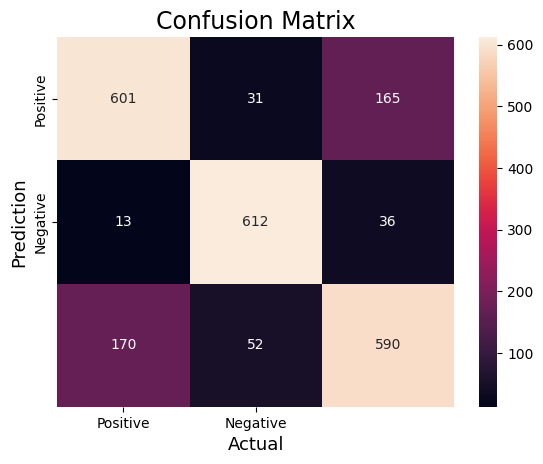

In [114]:
# Confusion matrix
confusion_mtx(targets_mbert, predictions_mbert)

79.5% Accuracy, 3 epochs, mBERT

80.1-80.2% Accuracy, 4 epochs, mBERT; 80.5% @ 5 epochs

### For IITP - Movie dataset

In [ ]:
eval_iitm_mbert, mdl_iitm_mbert = model_training('mbert_iitm', 'bert-base-multilingual-uncased', train_iitm, test_iitm)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

wrong predictions
320 wrong out of 620
{0: 105, 1: 169, 2: 46}


In [ ]:
accuracy_iitm_mbert, targets_iitm_mbert, predictions_iitm_mbert = evaluate_model(mdl_iitm_mbert, eval_iitm_mbert)

In [ ]:
print("Accuracy of trianing mbert is:", accuracy_iitm_mbert)
print("Classification report for mbert:",metrics.classification_report(targets_iitm_mbert, predictions_iitm_mbert))
#print("ROC AUC Curve score:",metrics.roc_auc_cruve(targets_iitm_mbert, predictions_iitm_mbert))

Accuracy of trianing mbert is: 0.4838709677419355
Classification report for mbert:               precision    recall  f1-score   support

           0       0.50      0.45      0.47       191
           1       0.00      0.00      0.00       169
           2       0.48      0.82      0.60       260

    accuracy                           0.48       620
   macro avg       0.33      0.42      0.36       620
weighted avg       0.35      0.48      0.40       620



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### For IITP - Product dataset

In [ ]:
eval_iitp_mbert, mdl_iitp_mbert = model_training('mbert_iitp', 'bert-base-multilingual-uncased', train_iitp, test_iitp)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

wrong predictions
520 wrong out of 1046
{1: 333, 0: 151, 2: 36}


In [ ]:
accuracy_iitp_mbert, targets_iitp_mbert, predictions_iitp_mbert = evaluate_model(mdl_iitp_mbert, eval_iitp_mbert)

In [ ]:
print("Accuracy of trianing mbert is:", accuracy_iitp_mbert)
print("Classification report for mbert:",metrics.classification_report(targets_iitp_mbert, predictions_iitp_mbert))
#print("ROC AUC Curve score:",metrics.roc_auc_cruve(targets_iitm_mbert, predictions_iitm_mbert))

Accuracy of trianing mbert is: 0.502868068833652
Classification report for mbert:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       151
           1       0.72      0.26      0.38       451
           2       0.46      0.92      0.62       444

    accuracy                           0.50      1046
   macro avg       0.39      0.39      0.33      1046
weighted avg       0.51      0.50      0.43      1046



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hindi-TPU-Electra

### For hi_3500.csv dataset

In [81]:
eval_frame_tpu_electra, mdl_tpu_electra = model_training('tpu_electra', 'monsoon-nlp/hindi-tpu-electra', train, test)

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at monsoon-nlp/hindi-tpu-electra were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.4.intermediate.dense.weight', 'electra.encoder.layer.0.output.LayerNorm.weight', 'electra.encoder.layer.7.output.dense.weight', 'electra.encoder.layer.6.attention.output.dense.bias', 'electra.encoder.layer.2.attention.self.value.weight', 'electra.encoder.layer.3.attention.self.value.weight', 'electra.encoder.layer.5.attention.output.LayerNorm.bias', 'electra.encoder.layer.10.output.dense.bias', 'electra.encoder.layer.1.attention.self.query.bias', 'electra.encoder.layer.4.intermediate.dense.bias', 'electra.encoder.layer.4.attention.self.value.weight', 'electra.encoder.layer.7.attention.self.key.bias', 'electra.encoder.layer.10.attention.self.value.weight', 'electra.encoder.layer.3.attention.self.key.bias', 'electra.embeddings.LayerNorm.bias', 'electra.encoder.layer.6.attention.output.LayerNorm.bias', 'electra.encoder.layer.8.attenti

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text 

wrong predictions
492 wrong out of 2270
{0: 212, 2: 221, 1: 59}


In [82]:
accuracy_tpu_electra, targets_tpu_electra, predictions_tpu_electra = evaluate_model(mdl_tpu_electra, eval_frame_tpu_electra)

In [83]:
print("Accuracy of trianing mbert is:", accuracy_tpu_electra)
print("Classification report for mbert:",metrics.classification_report(targets_tpu_electra, predictions_tpu_electra))
#print("ROC AUC Curve score:",metrics.roc_auc_score(targets_mbert, predictions_mbert))

Accuracy of trianing mbert is: 0.7832599118942731
Classification report for mbert:               precision    recall  f1-score   support

           0       0.72      0.73      0.73       797
           1       0.91      0.91      0.91       661
           2       0.74      0.73      0.73       812

    accuracy                           0.78      2270
   macro avg       0.79      0.79      0.79      2270
weighted avg       0.78      0.78      0.78      2270



In [84]:
# ROC-AUC score
roc_auc_score_multiclass(targets_tpu_electra, predictions_tpu_electra)

{0: 0.7913053959135624, 1: 0.936725529336213, 2: 0.7922427307804063}

Sensitivity score of the model: 0.9574468085106383
Specificity score of the model: 0.9435736677115988




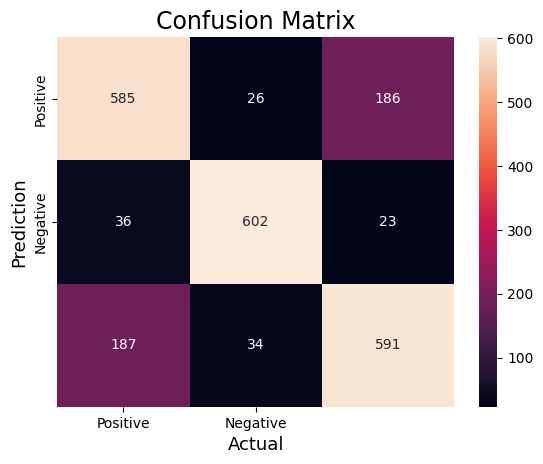

In [115]:
# Confusion matrix
confusion_mtx(targets_tpu_electra, predictions_tpu_electra)

In [ ]:
(1 - (433 / 2270)) * 100

80.9251101321586

79.5% Accuracy, 3 epochs, mBERT

80.1-80.2% Accuracy, 4 epochs, mBERT; 80.5% @ 5 epochs

### For IITP - Movie dataset

In [ ]:
eval_iitm_tpu_electra, mdl_iitm_tpu_electra = model_training('tpu_electra_iitm', 'monsoon-nlp/hindi-tpu-electra', train_iitm, test_iitm)

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at monsoon-nlp/hindi-tpu-electra were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.0.output.dense.bias', 'electra.encoder.layer.9.output.dense.weight', 'electra.encoder.layer.2.attention.output.dense.weight', 'electra.encoder.layer.2.attention.output.LayerNorm.bias', 'electra.encoder.layer.5.attention.self.value.bias', 'electra.encoder.layer.9.output.LayerNorm.bias', 'electra.encoder.layer.3.attention.output.dense.weight', 'electra.encoder.layer.7.attention.output.dense.weight', 'electra.encoder.layer.11.attention.output.LayerNorm.bias', 'electra.encoder.layer.0.output.dense.weight', 'electra.encoder.layer.4.attention.output.dense.weight', 'electra.encoder.layer.10.intermediate.dense.weight', 'electra.encoder.layer.6.output.LayerNorm.weight', 'electra.encoder.laye

wrong predictions
360 wrong out of 620
{0: 191, 1: 169}


In [ ]:
accuracy_iitm_tpu_electra, targets_iitm_tpu_electra, predictions_iitm_tpu_electra = evaluate_model(mdl_iitm_tpu_electra, eval_iitm_tpu_electra)

In [ ]:
print("Accuracy of trianing mbert is:", accuracy_iitm_tpu_electra)
print("Classification report for mbert:",metrics.classification_report(targets_iitm_tpu_electra, predictions_iitm_tpu_electra))
#print("ROC AUC Curve score:",metrics.roc_auc_cruve(targets_iitm_mbert, predictions_iitm_mbert))

Accuracy of trianing mbert is: 0.41935483870967744
Classification report for mbert:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       191
           1       0.00      0.00      0.00       169
           2       0.42      1.00      0.59       260

    accuracy                           0.42       620
   macro avg       0.14      0.33      0.20       620
weighted avg       0.18      0.42      0.25       620



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### For IITP - Product dataset

In [ ]:
eval_iitp_tpu_electra, mdl_iitp_tpu_electra = model_training('tpu_electra_iitp', 'monsoon-nlp/hindi-tpu-electra', train_iitp, test_iitp)

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at monsoon-nlp/hindi-tpu-electra were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.0.output.dense.bias', 'electra.encoder.layer.9.output.dense.weight', 'electra.encoder.layer.2.attention.output.dense.weight', 'electra.encoder.layer.2.attention.output.LayerNorm.bias', 'electra.encoder.layer.5.attention.self.value.bias', 'electra.encoder.layer.9.output.LayerNorm.bias', 'electra.encoder.layer.3.attention.output.dense.weight', 'electra.encoder.layer.7.attention.output.dense.weight', 'electra.encoder.layer.11.attention.output.LayerNorm.bias', 'electra.encoder.layer.0.output.dense.weight', 'electra.encoder.layer.4.attention.output.dense.weight', 'electra.encoder.layer.10.intermediate.dense.weight', 'electra.encoder.layer.6.output.LayerNorm.weight', 'electra.encoder.laye

wrong predictions
394 wrong out of 1046
{0: 145, 2: 115, 1: 134}


In [ ]:
accuracy_iitp_tpu_electra, targets_iitp_tpu_electra, predictions_iitp_tpu_electra = evaluate_model(mdl_iitp_tpu_electra, eval_iitp_tpu_electra)

In [ ]:
print("Accuracy of trianing mbert is:", accuracy_iitp_tpu_electra)
print("Classification report for mbert:",metrics.classification_report(targets_iitp_tpu_electra, predictions_iitp_tpu_electra))
#print("ROC AUC Curve score:",metrics.roc_auc_cruve(targets_iitm_mbert, predictions_iitm_mbert))

Accuracy of trianing mbert is: 0.6233269598470363
Classification report for mbert:               precision    recall  f1-score   support

           0       0.12      0.04      0.06       151
           1       0.65      0.70      0.68       451
           2       0.65      0.74      0.69       444

    accuracy                           0.62      1046
   macro avg       0.47      0.49      0.48      1046
weighted avg       0.57      0.62      0.59      1046



78.6-79.9% after 3 epochs at 18.6% complete

75.9-76.0 3 epochs 37.7%; 80.8% at 4 epochs; 81% at 5 epochs

80.8% at 3 epochs @ 47.3% trained, 80.5% at 4 epochs; 82.2% at 5 epochs

tried 61.4% trained, rolled back

## Bench-marking these models against our model

### For hi_3500.csv dataset

In [118]:
eval_frame_roberta, mdl_roberta = model_training('roberta', 'AshiNLP/Hindi-RoBERTa', train, test)

Some weights of the model checkpoint at AshiNLP/Hindi-RoBERTa were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at AshiNLP/Hindi-RoBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weig

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


wrong predictions
348 wrong out of 2270
{0: 133, 2: 176, 1: 39}


In [119]:
accuracy_roberta, targets_roberta, predictions_roberta = evaluate_model(mdl_roberta, eval_frame_roberta)

In [120]:
print("Accuracy of trianing mbert is:", accuracy_roberta)
print("Classification report for mbert:",metrics.classification_report(targets_roberta, predictions_roberta))
#print("ROC AUC Curve score:",metrics.roc_auc_score(targets_mbert, predictions_mbert))

Accuracy of trianing mbert is: 0.8466960352422908
Classification report for mbert:               precision    recall  f1-score   support

           0       0.80      0.83      0.82       797
           1       0.93      0.94      0.93       661
           2       0.83      0.78      0.81       812

    accuracy                           0.85      2270
   macro avg       0.85      0.85      0.85      2270
weighted avg       0.85      0.85      0.85      2270



In [121]:
# ROC-AUC score
roc_auc_score_multiclass(targets_roberta, predictions_roberta)

{0: 0.859535631326231, 1: 0.9555831466157177, 2: 0.8463581260516126}

Sensitivity score of the model: 0.967930029154519
Specificity score of the model: 0.971875




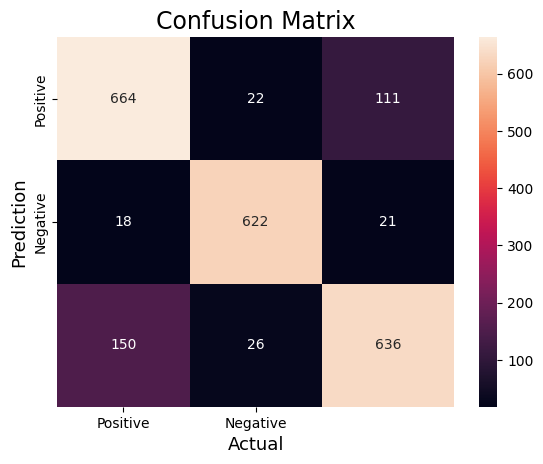

In [122]:
# Confusion matrix
confusion_mtx(targets_roberta, predictions_roberta)

In [ ]:
(1 - (363 / 2270)) * 100

84.00881057268722

### For IITP - Movie dataset

In [ ]:
eval_iitm_roberta, mdl_iitm_roberta = model_training('roberta_iitm', 'AshiNLP/Hindi-RoBERTa', train_iitm, test_iitm)

Some weights of the model checkpoint at AshiNLP/Hindi-RoBERTa were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at AshiNLP/Hindi-RoBERTa and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weig

wrong predictions
279 wrong out of 620
{0: 101, 2: 89, 1: 89}


In [ ]:
accuracy_iitm_roberta, targets_iitm_roberta, predictions_iitm_roberta = evaluate_model(mdl_iitm_roberta, eval_iitm_roberta)

In [ ]:
print("Accuracy of trianing mbert is:", accuracy_iitm_roberta)
print("Classification report for mbert:",metrics.classification_report(targets_iitm_roberta, predictions_iitm_roberta))
#print("ROC AUC Curve score:",metrics.roc_auc_cruve(targets_iitm_mbert, predictions_iitm_mbert))

Accuracy of trianing mbert is: 0.55
Classification report for mbert:               precision    recall  f1-score   support

           0       0.57      0.47      0.52       191
           1       0.46      0.47      0.47       169
           2       0.59      0.66      0.62       260

    accuracy                           0.55       620
   macro avg       0.54      0.53      0.54       620
weighted avg       0.55      0.55      0.55       620



### For IITP - Product dataset

In [ ]:
eval_iitp_roberta, mdl_iitp_roberta = model_training('roberta_iitp', 'AshiNLP/Hindi-RoBERTa', train_iitp, test_iitp)

Some weights of the model checkpoint at AshiNLP/Hindi-RoBERTa were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at AshiNLP/Hindi-RoBERTa and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weig

wrong predictions
291 wrong out of 1046
{0: 77, 2: 101, 1: 113}


In [ ]:
accuracy_iitp_roberta, targets_iitp_roberta, predictions_iitp_roberta = evaluate_model(mdl_iitp_roberta, eval_iitp_roberta)

In [ ]:
print("Accuracy of trianing mbert is:", accuracy_iitp_roberta)
print("Classification report for mbert:",metrics.classification_report(targets_iitp_roberta, predictions_iitp_roberta))
#print("ROC AUC Curve score:",metrics.roc_auc_cruve(targets_iitm_mbert, predictions_iitm_mbert))

Accuracy of trianing mbert is: 0.7217973231357553
Classification report for mbert:               precision    recall  f1-score   support

           0       0.65      0.49      0.56       151
           1       0.73      0.75      0.74       451
           2       0.73      0.77      0.75       444

    accuracy                           0.72      1046
   macro avg       0.70      0.67      0.68      1046
weighted avg       0.72      0.72      0.72      1046



## Tokenization check

In [ ]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis", model="AshiNLP/Hindi-RoBERTa")

Some weights of the model checkpoint at AshiNLP/Hindi-RoBERTa were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at AshiNLP/Hindi-RoBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bi

In [ ]:
result = sentiment_analysis('‡§Æ‡•Å‡§ù‡•á ‡§´‡§ø‡§≤‡•ç‡§Æ ‡§™‡§∏‡§Ç‡§¶ ‡§®‡§π‡•Ä‡§Ç ‡§Ü‡§à')
print(result)

[{'label': 'LABEL_1', 'score': 0.5405981540679932}]


In [ ]:
sentiment_analysis2 = pipeline("sentiment-analysis", model="monsoon-nlp/hindi-tpu-electra")

Some weights of the model checkpoint at monsoon-nlp/hindi-tpu-electra were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/hindi-tpu-electra and are newly initialized: ['classifier.dense.wei

In [ ]:
result = sentiment_analysis2('‡§Æ‡•Å‡§ù‡•á ‡§´‡§ø‡§≤‡•ç‡§Æ ‡§™‡§∏‡§Ç‡§¶ ‡§®‡§π‡•Ä‡§Ç ‡§Ü‡§à')
print(result)

[{'label': 'LABEL_0', 'score': 0.5000351071357727}]


In [ ]:
from transformers import AutoTokenizer
s = '‡§Æ‡•Å‡§ù‡•á ‡§´‡§ø‡§≤‡•ç‡§Æ ‡§™‡§∏‡§Ç‡§¶ ‡§π‡•à‡•§'
tokenizer = AutoTokenizer.from_pretrained('AshiNLP/Hindi-RoBERTa')
encoded = tokenizer.encode(s)
print(encoded)
tokenizer.decode(encoded)

[0, 295, 298, 459, 266, 371, 273, 285, 270, 295, 910, 275, 302, 288, 361, 2]


'<s>‡§Æ‡•Å‡§ù‡•á ‡§´‡§ø‡§≤‡•ç‡§Æ ‡§™‡§∏‡§Ç‡§¶ ‡§π‡•à‡•§</s>'

In [ ]:
from transformers import AutoTokenizer
s = '‡§µ‡§ø‡§ï‡§ø‡§™‡•Ä‡§°‡§ø‡§Ø‡§æ ‡§∏‡§≠‡•Ä ‡§µ‡§ø‡§∑‡§Ø‡•ã‡§Ç ‡§™‡§∞ ‡§™‡•ç‡§∞‡§æ‡§Æ‡§æ‡§£‡§ø‡§ï ‡§î‡§∞ ‡§â‡§™‡§Ø‡•ã‡§ó, ‡§™‡§∞‡§ø‡§µ‡§∞‡•ç‡§§‡§® ‡§µ ‡§™‡•Å‡§®‡§∞‡•ç‡§µ‡§ø‡§§‡§∞‡§£ ‡§ï‡•á ‡§≤‡§ø‡§è ‡§∏‡•ç‡§µ‡§§‡§®‡•ç‡§§‡•ç‡§∞ ‡§ú‡•ç‡§û‡§æ‡§®‡§ï‡•ã‡§∂ ‡§¨‡§®‡§æ‡§®‡•á ‡§ï‡§æ ‡§è‡§ï ‡§¨‡§π‡•Å‡§≠‡§æ‡§∑‡•Ä‡§Ø ‡§™‡•ç‡§∞‡§ï‡§≤‡•ç‡§™ ‡§π‡•à‡•§'
tokenizer = AutoTokenizer.from_pretrained('monsoon-nlp/hindi-tpu-electra')
encoded = tokenizer.encode(s)
print(encoded)
tokenizer.decode(encoded)

[3, 8798, 2376, 5147, 1912, 11928, 1900, 2380, 16, 3643, 477, 19821, 29329, 1075, 1885, 1948, 7567, 27771, 2971, 1899, 1909, 28969, 1038, 32491, 1886, 507, 4]


'[CLS] ‡§µ‡§ø‡§ï‡§ø‡§™‡•Ä‡§°‡§ø‡§Ø‡§æ ‡§∏‡§≠‡•Ä ‡§µ‡§ø‡§∑‡§Ø‡•ã‡§Ç ‡§™‡§∞ ‡§™‡•ç‡§∞‡§æ‡§Æ‡§æ‡§£‡§ø‡§ï ‡§î‡§∞ ‡§â‡§™‡§Ø‡•ã‡§ó, ‡§™‡§∞‡§ø‡§µ‡§∞‡•ç‡§§‡§® ‡§µ ‡§™‡•Å‡§®‡§∞‡•ç‡§µ‡§ø‡§§‡§∞‡§£ ‡§ï‡•á ‡§≤‡§ø‡§è ‡§∏‡•ç‡§µ‡§§‡§®‡•ç‡§§‡•ç‡§∞ ‡§ú‡•ç‡§û‡§æ‡§®‡§ï‡•ã‡§∂ ‡§¨‡§®‡§æ‡§®‡•á ‡§ï‡§æ ‡§è‡§ï ‡§¨‡§π‡•Å‡§≠‡§æ‡§∑‡•Ä‡§Ø ‡§™‡•ç‡§∞‡§ï‡§≤‡•ç‡§™ ‡§π‡•à ‡•§ [SEP]'

## Multi-label Hindi challenge

In [ ]:
import csv

rdr = csv.reader(open("./Constraint_Hindi_Train.csv", 'r'))
headers = None

processed = []

for row in rdr:
  if headers is None:
    headers = row
  else:
    processed.append([ row[1], [
      1 if 'non-hostile' in row[2] else 0,
      1 if 'hate' in row[2] else 0,
      1 if 'offensive' in row[2] else 0,
      1 if 'fake' in row[2] else 0,
      1 if 'defamation' in row[2] else 0,
    ]])
train_df = pd.DataFrame(processed)
train_df.head()

0                1
0  ‡§Æ‡•á‡§∞‡•á ‡§¶‡•á‡§∂ ‡§ï‡•á ‡§π‡§ø‡§®‡•ç‡§¶‡•Å ‡§¨‡§π‡•Å‡§§ ‡§®‡§ø‡§∞‡§æ‡§≤‡•á ‡§π‡•à‡•§ ‡§ï‡•Å‡§õ ‡§§‡•ã ‡§™‡§ï‡•ç‡§ï...  [0, 1, 1, 0, 0]
1  ‡§∏‡§∞‡§ï‡§æ‡§∞ ‡§π‡§Æ‡•á‡§∂‡§æ ‡§∏‡•á ‡§ï‡§ø‡§∏‡§æ‡§®‡•ã‡§Ç ‡§ï‡•Ä ‡§ï‡§Æ‡§æ‡§à ‡§ï‡•ã ‡§¨‡§¢‡§º‡§æ‡§®‡•á ‡§ï‡•á ‡§≤‡§ø...  [1, 0, 0, 0, 0]
2  ‡§∏‡•Å‡§∂‡§æ‡§Ç‡§§ ‡§®‡•á ‡§ú‡•ã ‡§¨‡§ø‡§ú‡§®‡•á‡§∏ ‡§°‡•Ä‡§≤ 9 ‡§ú‡•Ç‡§® ‡§ï‡•ã ‡§ï‡•Ä ‡§•‡•Ä, ‡§µ‡•ã ‡§°‡•Ä‡§≤...  [1, 0, 0, 0, 0]
3  @prabhav218 ‡§∏‡§æ‡§≤‡•á ‡§ú‡•á‡§è‡§®‡§Ø‡•Ç ‡§õ‡§æ‡§™ ‡§ï‡§Æ‡§ø‡§®‡•á ‡§≤‡•ã‡§ó ‡§π‡§ø‡§®‡•ç‡§¶‡•Å‡§ì‡§Ç...  [0, 0, 1, 0, 1]
4  #unlock4guidelines - ‡§Ö‡§®‡§≤‡•â‡§ï-4 ‡§ï‡•á ‡§≤‡§ø‡§è ‡§ó‡§æ‡§á‡§°‡§≤‡§æ‡§á‡§®‡•ç‡§∏...  [1, 0, 0, 0, 0]

In [ ]:
from simpletransformers.classification import MultiLabelClassificationModel

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
model = MultiLabelClassificationModel(
    'electra',
    'monsoon-nlp/hindi-tpu-electra',
    num_labels=5,
    args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs': 1}
)
model.train_model(train_df)

Some weights of the model checkpoint at monsoon-nlp/hindi-tpu-electra were not used when initializing ElectraForMultiLabelSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMultiLabelSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/hindi-tpu-electra and are n

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f1330390ef0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f1311d0fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(716, 0.4983071446127399)

In [ ]:
rdr = csv.reader(open("./Constraint_Hindi_Valid.csv", 'r'))
headers = None

validp = []
txts = []

for row in rdr:
  if headers is None:
    headers = row
  else:
    txts.append(row[1])
    validp.append([ row[1], [
      1 if 'non-hostile' in row[2] else 0,
      1 if 'hate' in row[2] else 0,
      1 if 'offensive' in row[2] else 0,
      1 if 'fake' in row[2] else 0,
      1 if 'defamation' in row[2] else 0,
    ]])
valid_df = pd.DataFrame(validp)
valid_df.head()

0                1
0  ‡§¶‡•É‡§¢‡§º ‡§á‡§ö‡•ç‡§õ‡§æ ‡§∂‡§ï‡•ç‡§§‡§ø ‡§∏‡•á ‡§™‡§∞‡§ø‡§™‡•Ç‡§∞‡•ç‡§£ ‡§™‡•ç‡§∞‡§£‡§¨‡§¶‡§æ ‡§ï‡•á ‡§≤‡§ø‡§è ‡§¶‡•á...  [1, 0, 0, 0, 0]
1  ‡§≠‡§æ‡§∞‡§§‡•Ä‡§Ø ‡§ú‡§®‡§§‡§æ ‡§™‡§æ‡§∞‡•ç‡§ü‡•Ä rss ‡§µ‡§æ‡§≤‡•á ‡§á‡§§‡§®‡•á ‡§ó‡§ø‡§∞‡•á ‡§π‡•Å‡§è ‡§π‡•à‡§Ç ...  [0, 0, 0, 0, 1]
2  ‡§ï‡•ã‡§∞‡•ã‡§®‡§æ ‡§∏‡•á ‡§®‡§ø‡§™‡§ü‡§®‡•á ‡§ï‡•Ä ‡§§‡•à‡§Ø‡§æ‡§∞‡•Ä / ‡§¶‡§ø‡§≤‡•ç‡§≤‡•Ä ‡§Æ‡•á‡§Ç 10 ‡§π‡§ú‡§æ...  [1, 0, 0, 0, 0]
3  ‡§ó‡§µ‡§∞‡•ç‡§®‡§∞ ‡§ï‡•â‡§®‡•ç‡§´‡•ç‡§∞‡•á‡§Ç‡§∏ ‡§Æ‡•á‡§Ç PM ‡§Æ‡•ã‡§¶‡•Ä ‡§¨‡•ã‡§≤‡•á- ‡§∂‡§ø‡§ï‡•ç‡§∑‡§æ ‡§®‡•Ä‡§§...  [1, 0, 0, 0, 0]
4  ‡§Ø‡•Ç‡§™‡•Ä: ‡§ó‡§æ‡§ú‡•Ä‡§™‡•Å‡§∞ ‡§Æ‡•á‡§Ç Toilet ‡§ò‡•ã‡§ü‡§æ‡§≤‡§æ, ‡§™‡•ç‡§∞‡§ß‡§æ‡§® ‡§µ ‡§∏‡§ö‡§ø‡§µ...  [1, 0, 0, 0, 0]

In [ ]:
labels, raws = model.predict(txts, multi_label=True)

index = 0
matches = 0
for row in validp:
  if row[1] == labels[index]:
    matches += 1
  # else:
  #   print("no match")
  #   print(row[1])
  #   print(labels[index])
  index += 1

In [ ]:
# exact matches 53.6% of the time
# some weird issue using eval_model, had returned 0/0
matches / len(validp)

0.5363748458692972

In [ ]:
result

{'LRAP': 0.7139214275928205, 'eval_loss': 0.455153253002494}